In [1]:
import os, sys

import pymongo as pm
import numpy as np
import scipy.stats as stats
import math
import pandas as pd
import json
import re
from io import BytesIO
from PIL import Image
import requests # this is to access the stim urls from the notebook
from IPython.display import SVG, display # need for showing stims with sketches side by side
import base64
import PIL

import matplotlib
from matplotlib import pylab, mlab, pyplot
import matplotlib.patches as mpatches
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('talk')
sns.set_style('white')
from matplotlib import rcParams
matplotlib.rcParams['pdf.fonttype'] = 42

from IPython.display import clear_output
import importlib

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

# so dataframes don't get cut off in display:
#pd.set_option("display.max_rows", None, "display.max_columns", None)

# a way to hide the little red error warnings that show up sometimes: (https://stackoverflow.com/questions/9031783/hide-all-warnings-in-ipython)    
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')


### set up paths

In [15]:
# directory & file hierarchy
proj_dir = os.path.abspath('..')
analysis_dir = os.getcwd()
results_dir = os.path.join(proj_dir,'results')
plot_dir = os.path.join(results_dir,'plots')
csv_dir = os.path.join(results_dir,'csv')
exp_dir = os.path.abspath(os.path.join(proj_dir,'experiments'))
sketch_dir = os.path.abspath(os.path.join(proj_dir,'sketches'))
gallery_dir = os.path.abspath(os.path.join(proj_dir,'gallery'))
datastructures_dir = os.path.join(analysis_dir,'datastructures')

## add helpers to python path
if os.path.join(proj_dir,'utils') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'utils'))   

def make_dir_if_not_exists(dir_name):   
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
    return dir_name

## create directories that don't already exist        
result = [make_dir_if_not_exists(x) for x in [results_dir,plot_dir,csv_dir,sketch_dir,gallery_dir,datastructures_dir]]

## add utils to python path
import sys
if os.path.join(proj_dir,'utils') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'utils'))
import utils

### establish connection to mongo
first thing you need to do is to establish an ssh tunnel (aka remote port forwarding) to the server, so that requests to the mongodb can be made "as if" the mongodb server is running on your local computer. Run this from the command line before you begin data analysis if you plan to fetch data from mongo:

ssh -fNL 27020:127.0.0.1:27017 USER@cogtoolslab.org

In [16]:
! ssh -fNL 27020:127.0.0.1:27017 sholt@cogtoolslab.org

In [19]:
# set vars 
auth = pd.read_csv(os.path.join(analysis_dir,'auth.txt'), header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'cogtoolslab.org'

# have to fix this to be able to analyze from local
import pymongo as pm
import socket
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1:27017')
db = conn['iterated_number']
coll = db['iternum2_recog']

# which iteration name(s) should we use?
iterationNames = ['sebastian'] # pilot1, pilot2
iterationName = 'sebastian'

workers = list(coll.find({'iterationName':iterationName,'workerID': {"$ne": 'undefined'}}).distinct("workerID"))  #recog_gameID

for worker in workers:
    print(max(list(coll.find({'iterationName':iterationName,'workerID':worker}).distinct("recog_gameID"))))


In [20]:
coll.find({'iterationName':iterationName}).distinct("recog_gameID")

# coll.find({'iterationName':iterationName}).distinct("workerID")


['2663-c6f51e70-c898-45db-b6c9-6bb15611c9c9']

In [28]:
DF = pd.DataFrame(list(coll.find({'iterationName':iterationName})))
DF.rating

0      [1, 0, 1, 0, 0]
1      [0, 1, 1, 0, 0]
2      [1, 1, 1, 0, 0]
3      [1, 0, 0, 1, 0]
4      [0, 0, 0, 0, 1]
            ...       
135    [1, 0, 0, 0, 0]
136    [0, 1, 0, 0, 0]
137    [0, 1, 0, 0, 0]
138    [0, 1, 1, 0, 0]
139    [0, 0, 1, 0, 0]
Name: rating, Length: 140, dtype: object

(array([66., 66.,  8.,  0.,  0.]),
 array([1. , 1.8, 2.6, 3.4, 4.2, 5. ]),
 <BarContainer object of 5 artists>)

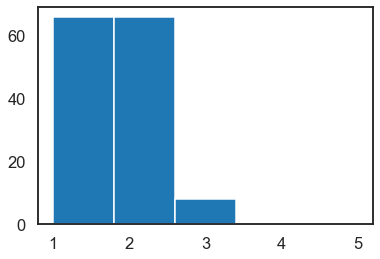

In [30]:
DF = pd.DataFrame(list(coll.find({'iterationName':iterationName})))
# DF = DF[DF['workerID'].apply(lambda x: isinstance(x, str))].reset_index() # get rid of wherever workerID is nan
# DF = DF.astype({'rating': str})

# old order:
# DF['uruk'] = DF['rating'].apply(lambda x: x[0])        # many-to-one
# DF['nippur'] = DF['rating'].apply(lambda x: x[1])      # one-to-one
# DF['suzdal'] = DF['rating'].apply(lambda x: x[2])      # arbitrary
# DF['mnist'] = DF['rating'].apply(lambda x: x[3])       # arabic
# DF['incomplete'] = DF['rating'].apply(lambda x: x[4])  # partial

DF['matching'] = DF['rating'].apply(lambda x: x[0])      # one-to-one
DF['grouping'] = DF['rating'].apply(lambda x: x[1])        # many-to-one
DF['clipping'] = DF['rating'].apply(lambda x: x[2])  # partial
DF['arabic'] = DF['rating'].apply(lambda x: x[3])       # arabic
DF['unique'] = DF['rating'].apply(lambda x: x[4])      # arbitrary

ratings = np.array(DF[['matching','grouping','clipping','arabic','unique']])

DF = DF[DF.rating_trial_num > 6]

plt.hist(np.sum(ratings,axis=1),bins=5,range=[1, 5])

In [52]:
catchTrials

,_id,iterationName,recog_gameID,workerID,assignmentID,hitID,turkSubmitTO,rating_trial_num,rating,RT,...,cardinality,origTrialNum,sketch_url,catch_trial,matching,grouping,clipping,arabic,unique,catchID
18,6178445651367d2c61dc4e61,pilot2,7653-b91fb6e6-85bb-4125-8e7a-7a697b0b38fb,A1HSSY8JC7RGZZ,33CKWXB73NKCLHYY0GWLMEEVFN1118,3BVS8WK9R4VLB1EUJI5EW5C38B3BIN,https://www.mturk.com,19,"[1, 1, 0, 0, 0]",4369,...,None,None,https://iternum-recog-catches.s3.amazonaws.com...,True,1,1,0,0,0,1
30,6178448351367d2c61dc4e6d,pilot2,7653-b91fb6e6-85bb-4125-8e7a-7a697b0b38fb,A1HSSY8JC7RGZZ,33CKWXB73NKCLHYY0GWLMEEVFN1118,3BVS8WK9R4VLB1EUJI5EW5C38B3BIN,https://www.mturk.com,31,"[0, 0, 0, 1, 0]",3170,...,None,None,https://iternum-recog-catches.s3.amazonaws.com...,True,0,0,0,1,0,4
42,617844b551367d2c61dc4e79,pilot2,7653-b91fb6e6-85bb-4125-8e7a-7a697b0b38fb,A1HSSY8JC7RGZZ,33CKWXB73NKCLHYY0GWLMEEVFN1118,3BVS8WK9R4VLB1EUJI5EW5C38B3BIN,https://www.mturk.com,43,"[0, 1, 1, 0, 0]",3925,...,None,None,https://iternum-recog-catches.s3.amazonaws.com...,True,0,1,1,0,0,2
54,6178451551367d2c61dc4e85,pilot2,7653-b91fb6e6-85bb-4125-8e7a-7a697b0b38fb,A1HSSY8JC7RGZZ,33CKWXB73NKCLHYY0GWLMEEVFN1118,3BVS8WK9R4VLB1EUJI5EW5C38B3BIN,https://www.mturk.com,55,"[0, 0, 1, 0, 0]",3899,...,None,None,https://iternum-recog-catches.s3.amazonaws.com...,True,0,0,1,0,0,3
69,6178456851367d2c61dc4e94,pilot2,7653-b91fb6e6-85bb-4125-8e7a-7a697b0b38fb,A1HSSY8JC7RGZZ,33CKWXB73NKCLHYY0GWLMEEVFN1118,3BVS8WK9R4VLB1EUJI5EW5C38B3BIN,https://www.mturk.com,70,"[0, 0, 0, 0, 1]",5470,...,None,None,https://iternum-recog-catches.s3.amazonaws.com...,True,0,0,0,0,1,5
89,6178463c51367d2c61dc4ea8,pilot2,5488-4fb719c4-b8e4-4a33-8f3b-5f6e613c8d59,A1HSSY8JC7RGZZ,33CKWXB73NKCLHYY0GWLMEEVFN1118,3BVS8WK9R4VLB1EUJI5EW5C38B3BIN,https://www.mturk.com,19,"[0, 0, 0, 0, 1]",2257,...,None,None,https://iternum-recog-catches.s3.amazonaws.com...,True,0,0,0,0,1,5
102,6178466351367d2c61dc4eb5,pilot2,5488-4fb719c4-b8e4-4a33-8f3b-5f6e613c8d59,A1HSSY8JC7RGZZ,33CKWXB73NKCLHYY0GWLMEEVFN1118,3BVS8WK9R4VLB1EUJI5EW5C38B3BIN,https://www.mturk.com,31,"[1, 0, 1, 0, 0]",2368,...,None,None,https://iternum-recog-catches.s3.amazonaws.com...,True,1,0,1,0,0,1
117,6178469b51367d2c61dc4ec4,pilot2,5488-4fb719c4-b8e4-4a33-8f3b-5f6e613c8d59,A1HSSY8JC7RGZZ,33CKWXB73NKCLHYY0GWLMEEVFN1118,3BVS8WK9R4VLB1EUJI5EW5C38B3BIN,https://www.mturk.com,43,"[0, 0, 0, 1, 0]",2173,...,None,None,https://iternum-recog-catches.s3.amazonaws.com...,True,0,0,0,1,0,4
132,617846d451367d2c61dc4ed3,pilot2,5488-4fb719c4-b8e4-4a33-8f3b-5f6e613c8d59,A1HSSY8JC7RGZZ,33CKWXB73NKCLHYY0GWLMEEVFN1118,3BVS8WK9R4VLB1EUJI5EW5C38B3BIN,https://www.mturk.com,55,"[0, 1, 1, 0, 0]",2396,...,None,None,https://iternum-recog-catches.s3.amazonaws.com...,True,0,1,1,0,0,2
149,6178470851367d2c61dc4ee4,pilot2,5488-4fb719c4-b8e4-4a33-8f3b-5f6e613c8d59,A1HSSY8JC7RGZZ,33CKWXB73NKCLHYY0GWLMEEVFN1118,3BVS8WK9R4VLB1EUJI5EW5C38B3BIN,https://www.mturk.com,70,"[0, 0, 1, 0, 0]",2542,...,None,None,https://iternum-recog-catches.s3.amazonaws.com...,True,0,0,1,0,0,3


/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


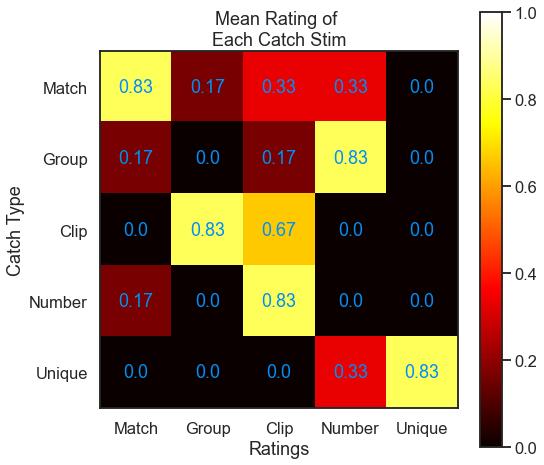

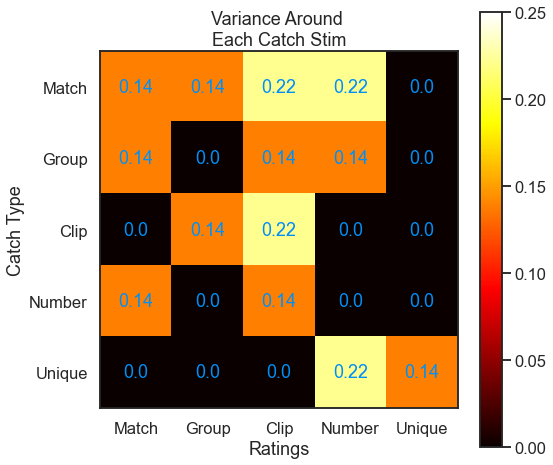

In [58]:
# start with catch trials
catchTrials = DF[DF['catch_trial'] == True]
catchTrials['catchID'] = catchTrials['sketch_url'].apply(lambda x: x.split('/')[-1].split('.')[0][-1])


catchVars = np.zeros((0,5))
catchMeans = np.zeros((0,5))

for catchID in catchTrials['catchID'].unique():
    catchRatings = np.array(catchTrials[catchTrials['catchID'] == catchID][['matching','grouping','clipping','arabic','unique']])
    catchVar = np.array([np.var(catchRatings,axis=0)])
    catchVars = np.append(catchVars,catchVar,axis=0)
    
    catchMean = np.array([np.mean(catchRatings,axis=0)])  # get mean value of each column (the rating), 1 row, 5 columns
    catchMeans = np.append(catchMeans,catchMean,axis=0)   # append that on the next row, N+1 rows, 5 columns

plt.figure(figsize=(8,8))
plt.imshow(catchMeans,vmin=0, vmax=1, cmap='hot', interpolation='nearest')
plt.title("Mean Rating of \nEach Catch Stim")
plt.colorbar()
plt.xticks(ticks=[0,1,2,3,4],labels=["Match","Group","Clip","Number","Unique"])
plt.yticks(ticks=[0,1,2,3,4],labels=["Match","Group","Clip","Number","Unique"])
for i in range(np.shape(catchMeans)[0]):
    for j in range(np.shape(catchMeans)[1]):
        text = plt.text(j, i, np.round(catchMeans[i, j],2),
                       ha="center", va="center", color="#008ff7")
plt.ylabel("Catch Type")
plt.xlabel("Ratings")
plt.show()

plt.figure(figsize=(8,8))
plt.imshow(catchVars,vmin=0, vmax=.25, cmap='hot', interpolation='nearest')
plt.title("Variance Around \nEach Catch Stim")
plt.colorbar()
plt.xticks(ticks=[0,1,2,3,4],labels=["Match","Group","Clip","Number","Unique"])
plt.yticks(ticks=[0,1,2,3,4],labels=["Match","Group","Clip","Number","Unique"])
for i in range(np.shape(catchVars)[0]):
    for j in range(np.shape(catchVars)[1]):
        text = plt.text(j, i, np.round(catchVars[i, j],2),
                       ha="center", va="center", color="#008ff7")
plt.ylabel("Catch Type")
plt.xlabel("Ratings")
plt.show()


In [49]:
x = np.array([[1,2],[3,4]])
x
np.sum(x,axis=1)


array([3, 7])

### This cell only to quickly visualize some pilot stuff from NumSyn, will make new ipynb later:

In [15]:


# numsynDB = conn['num_syn']
# numsynCOLL = numsynDB['proof_of_concept']
# numsynITER = 'sandbox'

# numsynCOLL.find({'iterationName':'friends1'}).distinct("gameID")



['0869-c27ed341-91b1-4b91-b08d-5742299e2967',
 '0540-6694adef-715f-41ae-b4ef-0bb4510d3a45']

In [27]:
# coll.find_one()
coll.find({'iterationName':'pilot2'}).distinct('recog_gameID')

['7653-b91fb6e6-85bb-4125-8e7a-7a697b0b38fb',
 '5488-4fb719c4-b8e4-4a33-8f3b-5f6e613c8d59',
 '0142-9d628b21-ea6a-4620-b978-34e0470b3865',
 '9078-e84d0b42-bf52-4e91-9630-4b14179aca54',
 '6271-edf135bd-65a3-4de4-a87e-48a903bc96ab',
 '2532-43969eac-2243-437a-8b24-ef45f1d034c4']

## Check that we're paying people something reasonable

Mean: 10.29 minutes. 
STD: 5.4 minutes. 
Games: 5
EV: $2.4 ± 1.26

Mean: nan minutes. 
STD: nan minutes. 
Complte Games: 0
EV: $nan ± nan


/Users/alles/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/alles/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/alles/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/Users/alles/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/Users/alles/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


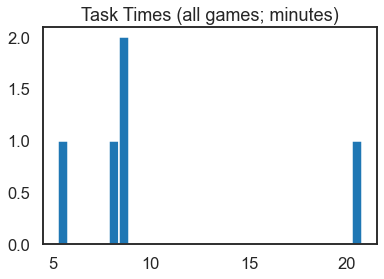

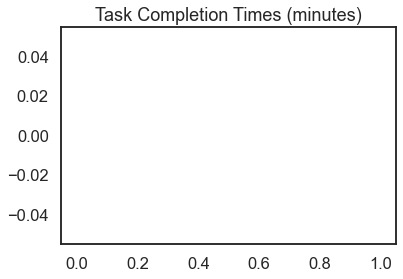

In [28]:
# look at the time every game took from start to finish
gamelist = list(coll.find({'iterationName':iterationName,'workerID': {"$ne": 'undefined'}}).distinct("recog_gameID"))
workers = list(coll.find({'iterationName':iterationName,'workerID': {"$ne": 'undefined'}}).distinct("workerID"))

gameDurations = []
completeGameDurations = []


for i,worker in enumerate(workers):
    print("Doing game #{} of {}".format(i+1,len(workers)))
    clear_output(wait=True)
    trials = list(coll.find({"workerID":worker}).distinct('rating_trial_num'))
    timeTaken = 0
    if len(trials) != 0:
        for t in trials:
            trialTime = coll.find({"workerID":worker,'rating_trial_num':t})[0]['RT']
            timeTaken += trialTime + 400
        gameDuration = (timeTaken / 1000) / 60
        gameDurations.append(gameDuration)
    if len(trials) == 64:
        for t in trials:
            trialTime = coll.find({"workerID":worker,'rating_trial_num':t})[0]['RT']
            timeTaken += trialTime + 400
        gameDuration = (timeTaken / 1000) / 60
        completeGameDurations.append(gameDuration)

# plot it for all games
meanMinutes = np.round(np.mean(gameDurations),2)
stdMinutes = np.round(np.std(gameDurations),2)
lenMinutes = len(gameDurations)

plt.figure()
plt.hist(gameDurations,bins=30)
plt.title("Task Times (all games; minutes)")

print("Mean: {} minutes. \nSTD: {} minutes. \nGames: {}".format(meanMinutes,stdMinutes,lenMinutes))
print("EV: ${} ± {}".format(np.round(14*(meanMinutes/60),2),np.round(14*(stdMinutes/60),2)))

# now just plot it for complete games
meanMinutes = np.round(np.mean(completeGameDurations),2)
stdMinutes = np.round(np.std(completeGameDurations),2)
lenMinutes = len(completeGameDurations)
print()
plt.figure()
plt.hist(completeGameDurations,bins=30)
plt.title("Task Completion Times (minutes)")

print("Mean: {} minutes. \nSTD: {} minutes. \nComplte Games: {}".format(meanMinutes,stdMinutes,lenMinutes))
print("EV: ${} ± {}".format(np.round(14*(meanMinutes/60),2),np.round(14*(stdMinutes/60),2)))


## Make a dataframe out of the mongo data

In [15]:

DF = pd.DataFrame(list(coll.find({'iterationName':'pilot1','workerID': {"$ne": 'undefined'}})))
DF = DF[DF['workerID'].apply(lambda x: isinstance(x, str))].reset_index() # get rid of wherever workerID is nan
# DF = DF.astype({'rating': str})

# old order:
# DF['uruk'] = DF['rating'].apply(lambda x: x[0])        # many-to-one
# DF['nippur'] = DF['rating'].apply(lambda x: x[1])      # one-to-one
# DF['suzdal'] = DF['rating'].apply(lambda x: x[2])      # arbitrary
# DF['mnist'] = DF['rating'].apply(lambda x: x[3])       # arabic
# DF['incomplete'] = DF['rating'].apply(lambda x: x[4])  # partial

DF['nippur'] = DF['rating'].apply(lambda x: x[0])      # one-to-one
DF['uruk'] = DF['rating'].apply(lambda x: x[1])        # many-to-one
DF['incomplete'] = DF['rating'].apply(lambda x: x[2])  # partial
DF['mnist'] = DF['rating'].apply(lambda x: x[3])       # arabic
DF['suzdal'] = DF['rating'].apply(lambda x: x[4])      # arbitrary

ratings = np.array(DF[['uruk','nippur','suzdal','mnist','incomplete']])

DF

,index,_id,iterationName,recog_gameID,workerID,assignmentID,hitID,turkSubmitTO,rating_trial_num,rating,...,animal,cardinality,origTrialNum,sketch_url,catch_trial,nippur,uruk,incomplete,mnist,suzdal
0,0,6165dcab4079e6024d817183,pilot1,0373-343faed2-9aed-401a-a2b1-be98b42da9a7,AWDPGQXB1ZJSB,3WAKVUDHU0G6504YRKNEYQA5RT47UO,3HKIF5DF72XORHT2VARFKN4X5IJ9GY,https://www.mturk.com,1,"[0, 0, 0, 1, 0]",...,None,None,None,https://iternum-recog-catches.s3.amazonaws.com...,True,0,0,0,1,0
1,1,6165dcb04079e6024d817184,pilot1,0373-343faed2-9aed-401a-a2b1-be98b42da9a7,AWDPGQXB1ZJSB,3WAKVUDHU0G6504YRKNEYQA5RT47UO,3HKIF5DF72XORHT2VARFKN4X5IJ9GY,https://www.mturk.com,2,"[1, 0, 0, 0, 0]",...,bear,19,4,https://iternum2-sketch-stims.s3.amazonaws.com...,False,1,0,0,0,0
2,2,6165dcb34079e6024d817185,pilot1,0373-343faed2-9aed-401a-a2b1-be98b42da9a7,AWDPGQXB1ZJSB,3WAKVUDHU0G6504YRKNEYQA5RT47UO,3HKIF5DF72XORHT2VARFKN4X5IJ9GY,https://www.mturk.com,3,"[0, 0, 1, 0, 0]",...,bear,18,27,https://iternum2-sketch-stims.s3.amazonaws.com...,False,0,0,1,0,0
3,3,6165dcb54079e6024d817186,pilot1,0373-343faed2-9aed-401a-a2b1-be98b42da9a7,AWDPGQXB1ZJSB,3WAKVUDHU0G6504YRKNEYQA5RT47UO,3HKIF5DF72XORHT2VARFKN4X5IJ9GY,https://www.mturk.com,4,"[0, 1, 0, 0, 0]",...,bear,15,9,https://iternum2-sketch-stims.s3.amazonaws.com...,False,0,1,0,0,0
4,4,6165dcb64079e6024d817187,pilot1,3924-5e518cff-dc22-4576-8114-76ae67f7a6e9,ABW8U1U74P8MI,33LKR6A5KIKDU1A72ZGVSKXQ5TWT1L,3HKIF5DF72XORHT2VARFKN4X5IJ9GY,https://www.mturk.com,1,"[0, 0, 0, 1, 1]",...,None,None,None,https://iternum-recog-catches.s3.amazonaws.com...,True,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,379,6165e5904079e6024d8172fe,pilot1,6173-fcfcbcd1-f790-4c9c-8874-2f0723ed39f1,A183WYXN12P2TJ,358UUM7WR33EP8CHNQS9TFNLKU07RK,3HKIF5DF72XORHT2VARFKN4X5IJ9GY,https://www.mturk.com,60,"[1, 1, 0, 0, 0]",...,bear,17,5,https://iternum2-sketch-stims.s3.amazonaws.com...,False,1,1,0,0,0
380,380,6165e5934079e6024d8172ff,pilot1,6173-fcfcbcd1-f790-4c9c-8874-2f0723ed39f1,A183WYXN12P2TJ,358UUM7WR33EP8CHNQS9TFNLKU07RK,3HKIF5DF72XORHT2VARFKN4X5IJ9GY,https://www.mturk.com,61,"[0, 1, 1, 0, 0]",...,deer,18,36,https://iternum2-sketch-stims.s3.amazonaws.com...,False,0,1,1,0,0
381,381,6165e5964079e6024d817300,pilot1,6173-fcfcbcd1-f790-4c9c-8874-2f0723ed39f1,A183WYXN12P2TJ,358UUM7WR33EP8CHNQS9TFNLKU07RK,3HKIF5DF72XORHT2VARFKN4X5IJ9GY,https://www.mturk.com,62,"[1, 0, 0, 0, 0]",...,bear,16,36,https://iternum2-sketch-stims.s3.amazonaws.com...,False,1,0,0,0,0
382,382,6165e5994079e6024d817301,pilot1,6173-fcfcbcd1-f790-4c9c-8874-2f0723ed39f1,A183WYXN12P2TJ,358UUM7WR33EP8CHNQS9TFNLKU07RK,3HKIF5DF72XORHT2VARFKN4X5IJ9GY,https://www.mturk.com,63,"[0, 1, 0, 0, 0]",...,deer,16,32,https://iternum2-sketch-stims.s3.amazonaws.com...,False,0,1,0,0,0


## Visualize people's individual sketch ratings and save them out

In [17]:

i = 0
for row in DF.iterrows():
    i += 1
    print("Currently on row #{} of {}".format(i,len(DF)))
    clear_output(wait=True)
    rownum = str(row[0])
    while len(rownum) < 3:
        rownum = '0' + rownum
    fname = str(ratings[row[0]])[1:-1].replace(' ','_') + '_' + rownum
    response = requests.get(row[1]['sketch_url'])
    img = Image.open(BytesIO(response.content)).save('../recogs/' + fname + '.png')
    

Currently on row #385 of 384


## Analyze agreement on similar sketches

/Users/alles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


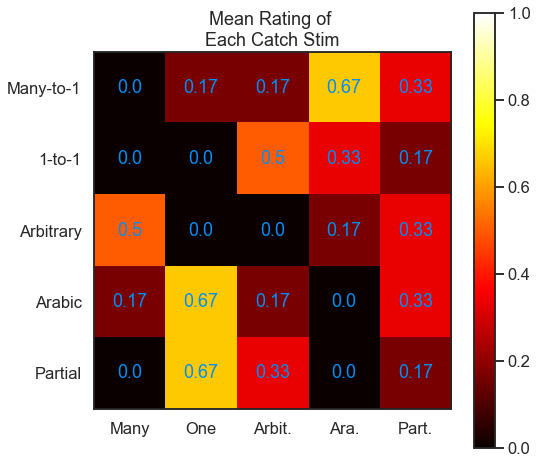

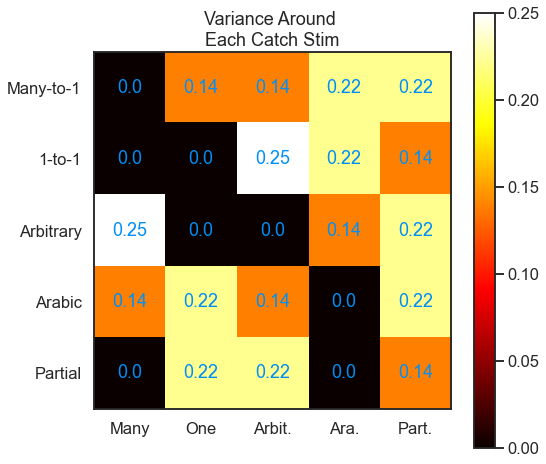

In [18]:
# start with catch trials
catchTrials = DF[DF['catch_trial'] == True]
catchTrials['catchID'] = catchTrials['sketch_url'].apply(lambda x: x.split('/')[-1].split('.')[0][-1])


catchVars = np.zeros((0,5))
catchMeans = np.zeros((0,5))

for catchID in catchTrials['catchID'].unique():
    catchRatings = np.array(catchTrials[catchTrials['catchID'] == catchID][['uruk','nippur','suzdal','mnist','incomplete']])
    catchVar = np.array([np.var(catchRatings,axis=0)])
    catchVars = np.append(catchVars,catchVar,axis=0)
    
    catchMean = np.array([np.mean(catchRatings,axis=0)])
    catchMeans = np.append(catchMeans,catchMean,axis=0)

plt.figure(figsize=(8,8))
plt.imshow(catchMeans,vmin=0, vmax=1, cmap='hot', interpolation='nearest')
plt.title("Mean Rating of \nEach Catch Stim")
plt.colorbar()
plt.xticks(ticks=[0,1,2,3,4],labels=["Many","One","Arbit.","Ara.","Part."])
plt.yticks(ticks=[0,1,2,3,4],labels=["Many-to-1","1-to-1","Arbitrary","Arabic","Partial"])
for i in range(np.shape(catchMeans)[0]):
    for j in range(np.shape(catchMeans)[1]):
        text = plt.text(j, i, np.round(catchMeans[i, j],2),
                       ha="center", va="center", color="#008ff7")
plt.show()

plt.figure(figsize=(8,8))
plt.imshow(catchVars,vmin=0, vmax=.25, cmap='hot', interpolation='nearest')
plt.title("Variance Around \nEach Catch Stim")
plt.colorbar()
plt.xticks(ticks=[0,1,2,3,4],labels=["Many","One","Arbit.","Ara.","Part."])
plt.yticks(ticks=[0,1,2,3,4],labels=["Many-to-1","1-to-1","Arbitrary","Arabic","Partial"])
for i in range(np.shape(catchVars)[0]):
    for j in range(np.shape(catchVars)[1]):
        text = plt.text(j, i, np.round(catchVars[i, j],2),
                       ha="center", va="center", color="#008ff7")
plt.show()


In [36]:
ratings

array([[0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ...,
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 1]])

(array([316.,  60.,   8.,   0.,   0.]),
 array([1. , 1.8, 2.6, 3.4, 4.2, 5. ]),
 <BarContainer object of 5 artists>)

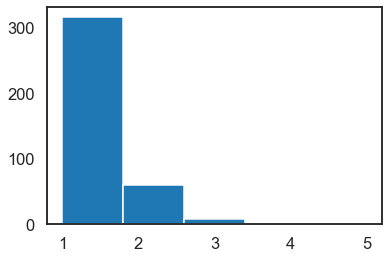

In [20]:

plt.hist(np.sum(ratings,axis=1),bins=5,range=[1, 5])


In [22]:
np.mean(ratings,axis=0)

array([0.34895833, 0.2890625 , 0.13541667, 0.1484375 , 0.27604167])

In [24]:
np.var(ratings,axis=1)

array([0.16, 0.16, 0.16, 0.16, 0.24, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16,
       0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.24,
       0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16,
       0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.24,
       0.16, 0.16, 0.16, 0.24, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16,
       0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16,
       0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16,
       0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16,
       0.16, 0.16, 0.16, 0.16, 0.24, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16,
       0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.24, 0.16, 0.16, 0.16, 0.16,
       0.24, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16,
       0.16, 0.16, 0.24, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16,
       0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16,
       0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.24, 0.